In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:

!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
... resuming from 234881024 bytes (89559133 bytes left) ...
 99% 307M/309M [00:04<00:00, 24.0MB/s]
100% 309M/309M [00:04<00:00, 19.1MB/s]


In [ ]:

!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [ ]:
train_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/train'
validation_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ['angry', 'happy', 'sad']

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)


Found 6799 files belonging to 3 classes.


In [ ]:


val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 89.      ,  89.      ,  89.      ],
         [ 91.4375  ,  91.4375  ,  91.4375  ],
         [ 85.8125  ,  85.8125  ,  85.8125  ],
         ...,
         [ 26.6875  ,  26.6875  ,  26.6875  ],
         [ 26.      ,  26.      ,  26.      ],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 79.25    ,  79.25    ,  79.25    ],
         [ 86.30859 ,  86.30859 ,  86.30859 ],
         [ 87.89453 ,  87.89453 ,  87.89453 ],
         ...,
         [ 25.875   ,  25.875   ,  25.875   ],
         [ 25.339844,  25.339844,  25.339844],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 71.5     ,  71.5     ,  71.5     ],
         [ 79.625   ,  79.625   ,  79.625   ],
         [ 87.60156 ,  87.60156 ,  87.60156 ],
         ...,
         [ 24.570312,  24.570312,  24.570312],
         [ 23.253906,  23.253906,  23.253906],
         [ 24.625   ,  24.625   ,  24.625   ]],

        ...,

        [[170.      , 170.      ,

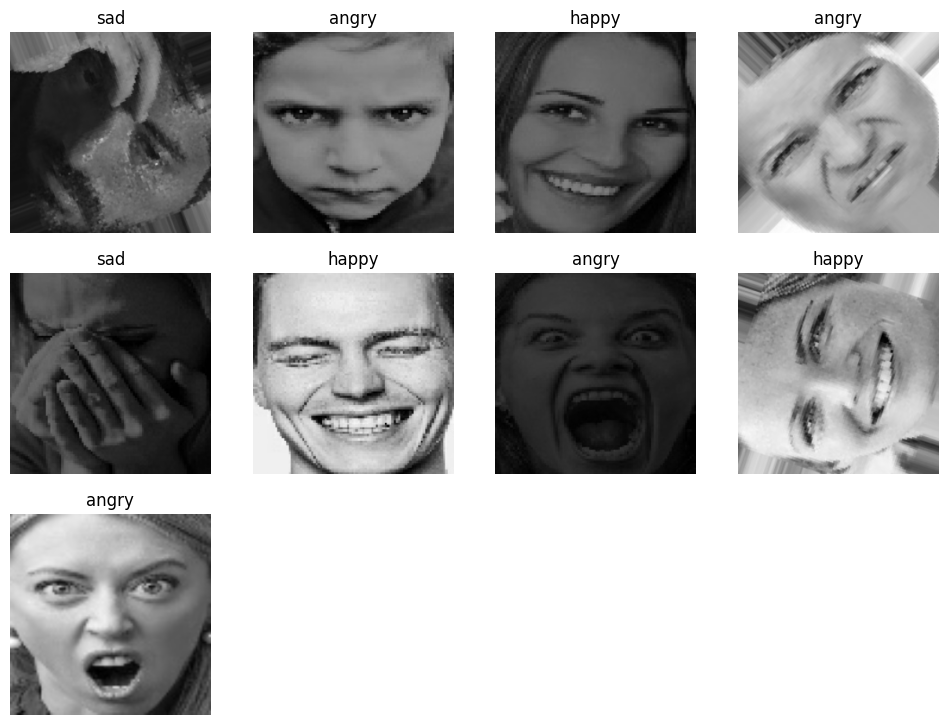

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(4, 4 , i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis("off")

In [ ]:
trian_dataset =(
    train_dataset.prefetch(tf.data.AUTOTUNE)
)
val_dataset =(
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
  Resizing(256, 256),
  Rescaling(1./255)
])

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      62,981,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

In [ ]:
loss_function = CategoricalCrossentropy(from_logits = False)
optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"])
metrics = [CategoricalAccuracy(name = 'accuracy'),TopKCategoricalAccuracy(k=2, name ='top_k_accuracy')]

In [ ]:
lenet_model.compile(optimizer = optimizer, loss = loss_function, metrics = metrics)

In [ ]:
history = lenet_model.fit(trian_dataset, validation_data = val_dataset, epochs = CONFIGURATION["N_EPOCHS"], verbose = 1)

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.5023 - loss: 1.1265 - top_k_accuracy: 0.7962 - val_accuracy: 0.3810 - val_loss: 1.2122 - val_top_k_accuracy: 0.7897
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.7319 - loss: 0.6405 - top_k_accuracy: 0.9146 - val_accuracy: 0.6106 - val_loss: 0.9342 - val_top_k_accuracy: 0.8753
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.8293 - loss: 0.4502 - top_k_accuracy: 0.9524 - val_accuracy: 0.6067 - val_loss: 1.0770 - val_top_k_accuracy: 0.8442
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.8887 - loss: 0.3151 - top_k_accuracy: 0.9775 - val_accuracy: 0.4372 - val_loss: 1.9683 - val_top_k_accuracy: 0.6971
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.9222 - loss: 0.2312 - top_k_accuracy: 0.9870 - val_accuracy: 0.5452 - val_loss: 1.2607 - val_top_k_accuracy: 0.8051
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9367 - loss

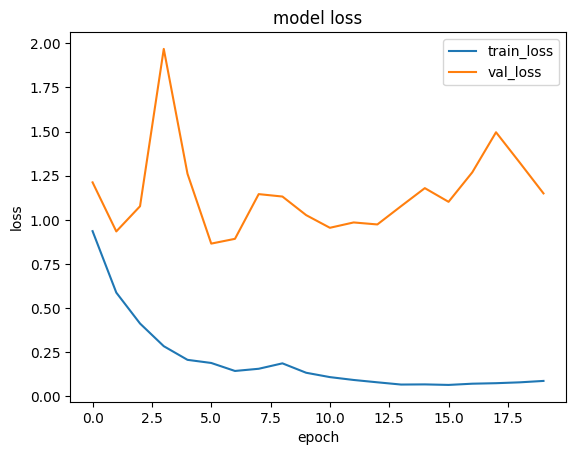

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [26]:
lenet_model.evaluate(val_dataset)

2278/2278 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7520 - loss: 1.1542 - top_k_accuracy: 0.9101


[1.1497175693511963, 0.7475855946540833, 0.9108867645263672]

In [40]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/108893.jpg")

In [41]:
im = tf.constant(test_image, dtype=tf.float32)
print(im.shape)
im = tf.expand_dims(im, axis=0)
print(im.shape)

(90, 90, 3)
(1, 90, 90, 3)


In [42]:
print(CLASS_NAMES[tf.argmax(lenet_model(im), axis= -1).numpy()[0]])

sad
